## Task

Given a dataset that contains YouTube throughput samples, where:

- Each row is the data for 1 YouTube streaming session.
- The first field denotes whether a resolution downgrade event occured (e.g. 1080p -< 720p).
- The rest of the fields give the downloaded volume (in bytes) per 0.5 sec by the player from the start of the buffering to its end.

Create a model to predict the resolution downgrade events.

## Contents:
* [Analysis](#analysis)
    * [Visualizing some sessions](#vis-som-sess)
    * [Strength of first or last intervals](#str_of_interval)
    * [Zeros](#zeros)
    * [Groups of Zeros](#groups_of_zeros)
    * [Target](#target)
* [Modeling](#modeling)
    * [1. Naive Baseline](#naive)
    * [2. XGBoost on the raw data](#xgboost-raw-data)
    * [3. Fill NaNs with 0](#fill-nans-0)
    * [4. Repeat elemets to fill NaNs intervals](#repeat)
    * [5. Feature Engineering](#feat-eng)
    * [6. Adding these features to the initial](#add-to-init)              
    * [7. Feature Selection](#feat-sel)             
    * [8. Feature Selection on the Engineered Features](#feat-sel-eng)
    * [9. Feature Selection on Initial + Engineered Features](#feat-sel-eng2)        
* [Conclusions](#conc)
* [Next Steps](#next-steps)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy import signal

In [2]:
def read_file(file_name):
    '''
    Read csv. Name each column. Impute NaN to columns of shorter videos than the max
    '''
    data_file_delimiter = ','
    
    # The max column count a line in the file could have
    largest_column_count = 0

    # Loop the data lines
    with open(data_file, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()

        for l in lines:
            # Count the column count for the current line
            column_count = len(l.split(data_file_delimiter)) + 1

            # Set the new most column count
            largest_column_count = column_count if largest_column_count < column_count else largest_column_count
    # Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
    column_names = [i for i in range(0, largest_column_count)]
    
    # read with pandas 
    data = pd.read_csv(data_file, header=None, names=column_names)
    
    # remove last column with all NaNs
    data = data.dropna(axis=1, how='all')
    
    return data

In [3]:
data_file = 'data/vsa_sample_subset.csv'
data = read_file(file_name = data_file)

In [4]:
data

,0,1,2,3,4,5,6,7,8,9,...,5491,5492,5493,5494,5495,5496,5497,5498,5499,5500
0,0,121059,53520,51690.0,29.0,94378.0,81618.0,31736.0,75076.0,60509.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,58290,68266,14552.0,32369.0,5381.0,67110.0,61577.0,5486.0,29422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,184834,72531,133896.0,141118.0,114100.0,161196.0,149852.0,129972.0,63880.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,63526,20428,15263.0,16635.0,5560.0,17441.0,34080.0,5921.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,117264,83247,175868.0,99152.0,143166.0,44154.0,85661.0,111083.0,107040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,65024,72252,5827.0,32514.0,8028.0,21768.0,50828.0,66972.0,12040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,1,188329,34029,71081.0,114530.0,125860.0,100337.0,121001.0,109877.0,125772.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,0,119066,93309,34985.0,75296.0,114354.0,120184.0,44459.0,106646.0,111496.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,0,218013,69939,207734.0,101361.0,122930.0,112512.0,203464.0,131016.0,55795.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis <a id="analysis"></a>

Some plots in order to understand the data.

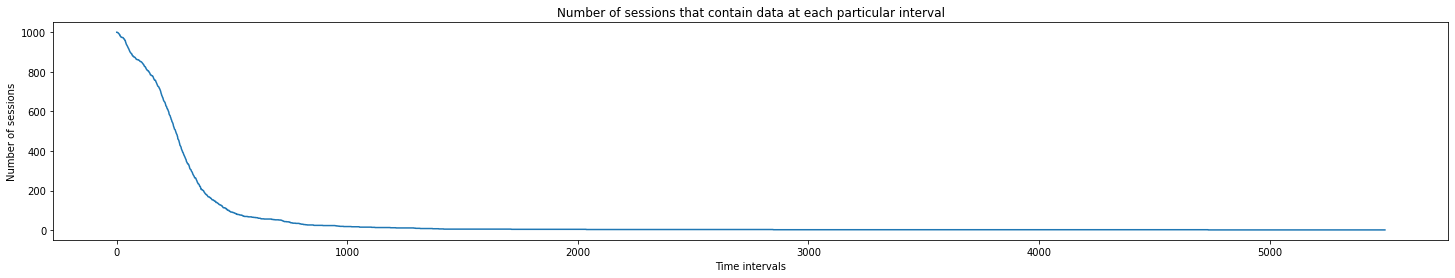

In [5]:
intervlas_with_data = len(data.drop(columns=[0])) - data.drop(columns=[0]).isnull().sum()
fig, ax = plt.subplots(figsize=(25, 4))
plt.plot(intervlas_with_data)
ax.set_ylabel('Number of sessions')
ax.set_xlabel('Time intervals')
plt.title("Number of sessions that contain data at each particular interval");

Most of the sessions are below 500 time intervals (250 seconds).

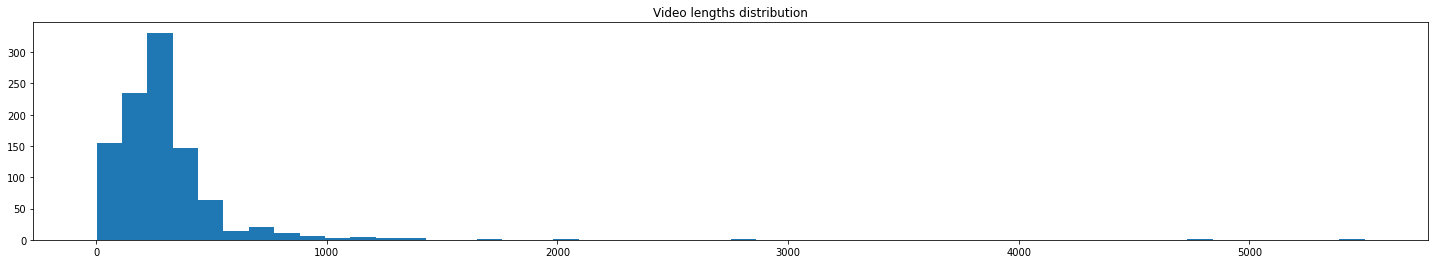

In [6]:
number_of_intervals = len(data.drop(columns=[0]).columns) - data.isnull().sum(axis=1)

fig, ax = plt.subplots(figsize=(25, 4))
plt.hist(number_of_intervals, bins=50)
plt.title("Video lengths distribution");

In [7]:
print(f"The average Video length is {number_of_intervals.mean()} and the median is {number_of_intervals.median()}"
      f"\nMinumum length is {number_of_intervals.min()} and maximum {number_of_intervals.max()}"
      f"\nSkewness is {number_of_intervals.skew():.1f}")

The average Video length is 295.926 and the median is 255.0
Minumum length is 2 and maximum 5500
Skewness is 8.8


Most videos have small lengths and the data is positive skewed.

Next, let's visualize the total size of the video downloaed.

In [8]:
video_sizes = data.drop(columns=[0]).sum(axis=1)

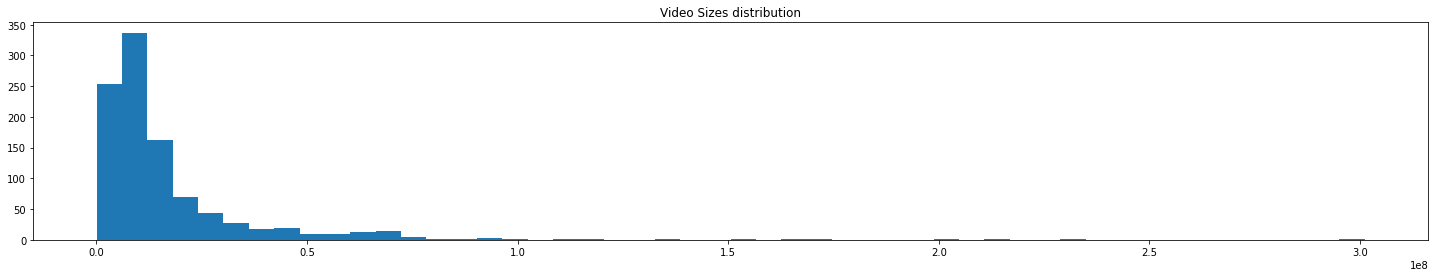

In [9]:
fig, ax = plt.subplots(figsize=(25, 4))
plt.hist(video_sizes, bins=50)
plt.title("Video Sizes distribution");

In [10]:
print(f"The average Video size is {video_sizes.mean()} and the median is {video_sizes.median()}"
      f"\nMinumum length is {video_sizes.min()} and maximum {video_sizes.max()}"
      f"\nSkewness is {video_sizes.skew():.1f}")

The average Video size is 17394463.164 and the median is 10360574.5
Minumum length is 43672.0 and maximum 301174274.0
Skewness is 5.1


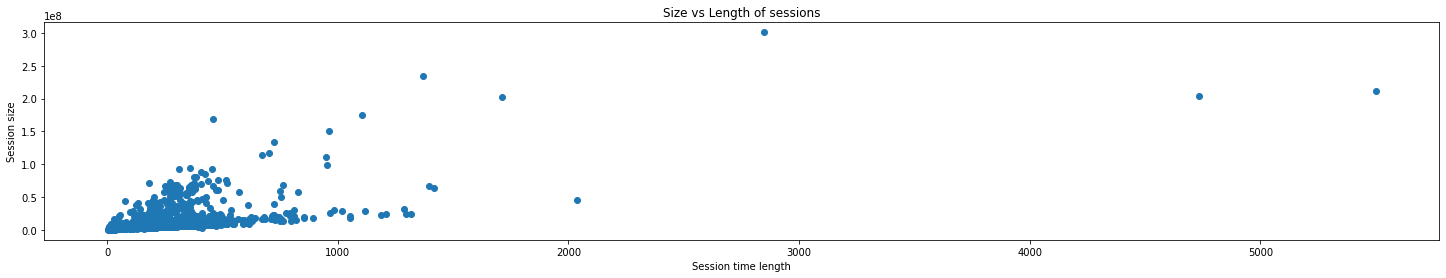

In [11]:
fig, ax = plt.subplots(figsize=(25, 4))
plt.scatter(number_of_intervals, video_sizes)
ax.set_ylabel('Session size')
ax.set_xlabel('Session time length')
plt.title("Size vs Length of sessions");

In [12]:
print(f"Correlation between size and length: {stats.pearsonr(number_of_intervals, video_sizes)[0]:.2f}")

Correlation between size and length: 0.61


### Visualizing some sessions <a id="vis-som-sess"></a>

In [13]:
# the session that has no missing values. it expands until 5500 half second
biggest_session = data.loc[data.isnull().sum(axis=1)==0].head(1)

# a big session
big_session = data.loc[data.isnull().sum(axis=1)==3789].head(1)

# sessions to visualize
sessions_sample = pd.concat([data.head(3), big_session, biggest_session]).reset_index(drop=True)

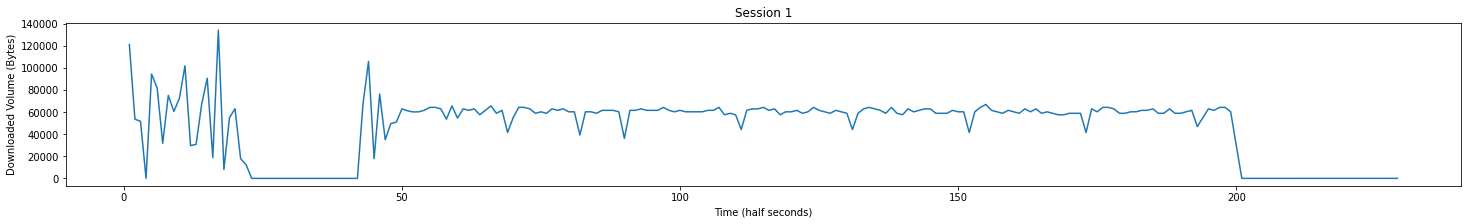

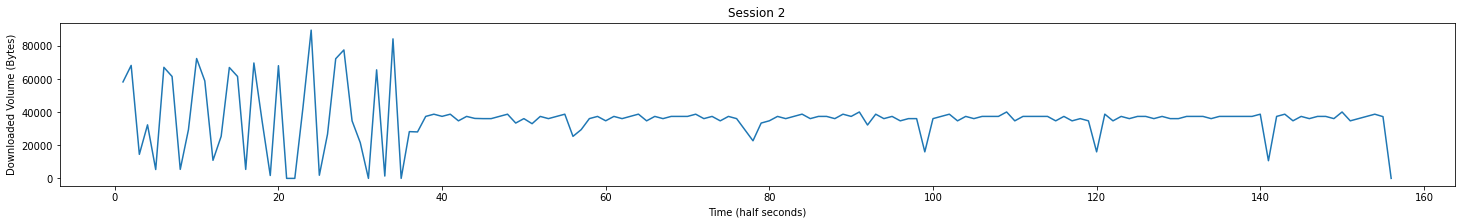

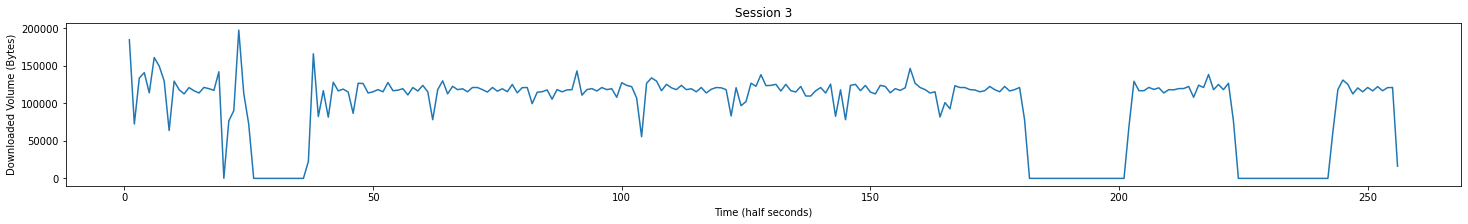

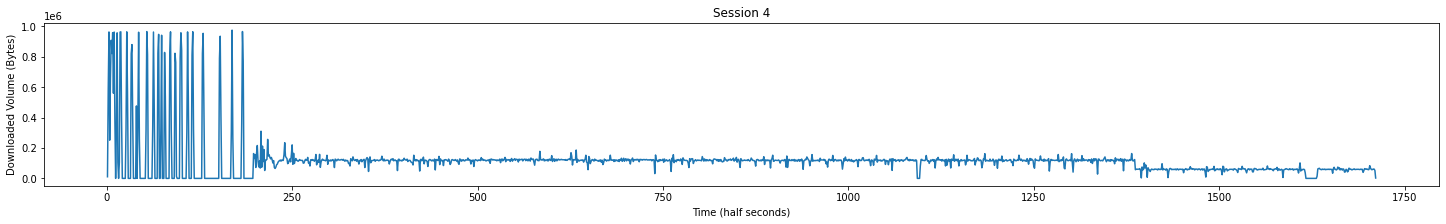

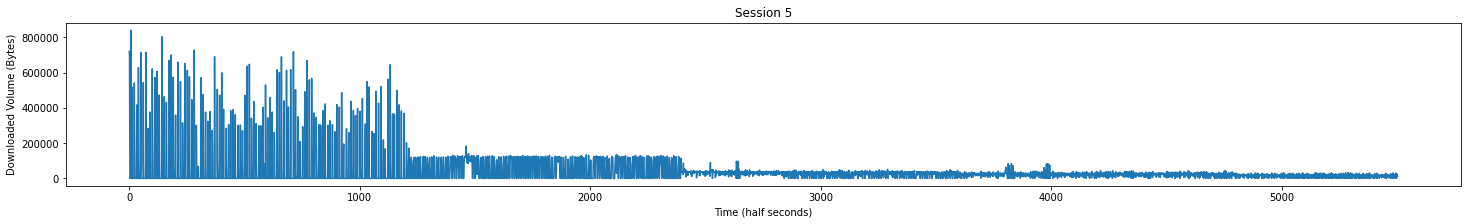

In [14]:
# visualize the 3 first sessions, one big session, and the biggest session
for i, row in sessions_sample.iterrows():
    session = sessions_sample.drop(columns=[0]).iloc[i]
    fig, ax = plt.subplots(figsize=(25, 3))
    plt.plot(session)
    ax.set_ylabel('Downloaded Volume (Bytes)')
    ax.set_xlabel('Time (half seconds)')
    plt.title(f'Session {i+1}');

From the above plots, a lot of new features can be created to describe each session.

Below, I will create some of them that might be important.

### Strength of first or last intervals <a id="str_of_interval"></a>

For strength, we divide the average volume of the first or last N intervals with the average volume of all intervals

In [15]:
def strength_of_intervals(x, number_of_intervals=1, kind='first'):
    if kind not in ['first', 'last']:
        raise ValueError("'kind' should be 'first' or 'last'.")
        
    if kind == 'first':
        average_of_volume_of_selected_intervals = np.mean(x.dropna().values[0:number_of_intervals])
    else:
        average_of_volume_of_selected_intervals = np.mean(x.dropna().values[-number_of_intervals:])
    average_of_volume_of_all_intervals = x.mean()
    strength = average_of_volume_of_selected_intervals/average_of_volume_of_all_intervals
    return strength

In [16]:
# strength of the first interval only
strength_of_first_intervals_1 = data.drop(columns=[0]).apply(lambda x: strength_of_intervals(x, number_of_intervals=1, kind='first'), axis=1)
# strength of the first 2 intervals only
strength_of_first_intervals_2 = data.drop(columns=[0]).apply(lambda x: strength_of_intervals(x, number_of_intervals=2, kind='first'), axis=1)
# strength of the first 10 intervals only
strength_of_first_intervals_10 = data.drop(columns=[0]).apply(lambda x: strength_of_intervals(x, number_of_intervals=10, kind='first'), axis=1)

# strength of the last interval only
strength_of_last_intervals_1 = data.drop(columns=[0]).apply(lambda x: strength_of_intervals(x, number_of_intervals=1, kind='last'), axis=1)
# strength of the last 2 intervals only
strength_of_last_intervals_2 = data.drop(columns=[0]).apply(lambda x: strength_of_intervals(x, number_of_intervals=2, kind='last'), axis=1)
# strength of the last 10 intervals only
strength_of_last_intervals_10 = data.drop(columns=[0]).apply(lambda x: strength_of_intervals(x, number_of_intervals=10, kind='last'), axis=1)

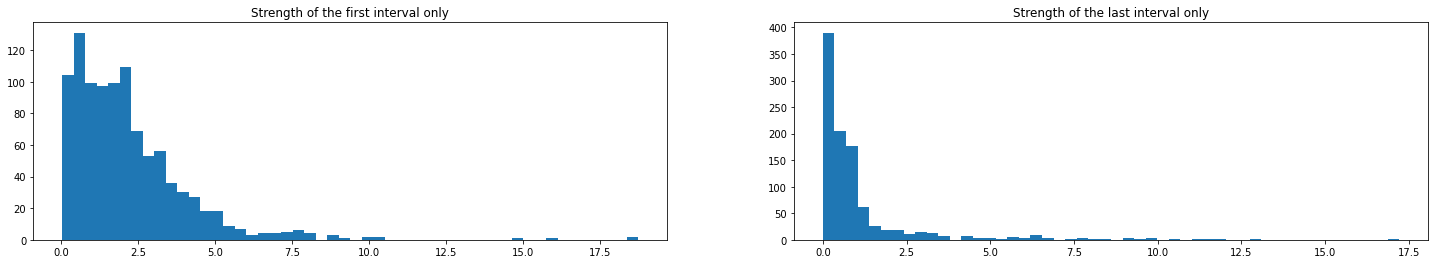

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(25, 4))
ax[0].hist(strength_of_first_intervals_1, bins=50)
ax[0].set_title("Strength of the first interval only");
ax[1].hist(strength_of_last_intervals_1, bins=50)
ax[1].set_title("Strength of the last interval only");

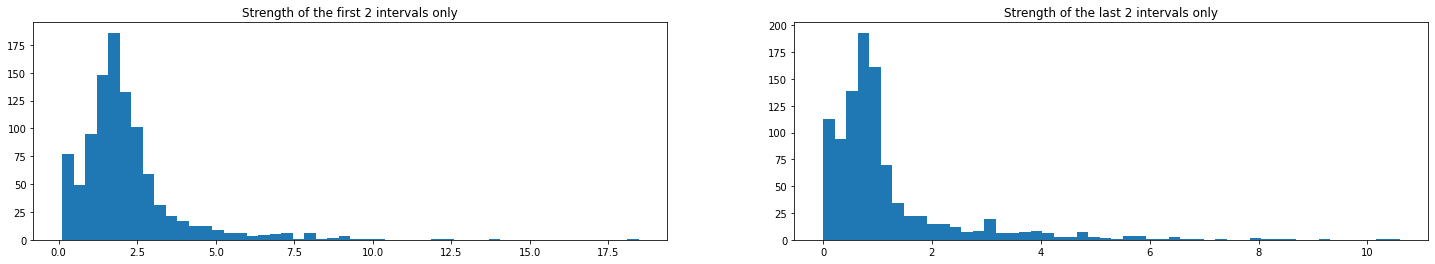

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(25, 4))
ax[0].hist(strength_of_first_intervals_2, bins=50)
ax[0].set_title("Strength of the first 2 intervals only");
ax[1].hist(strength_of_last_intervals_2, bins=50)
ax[1].set_title("Strength of the last 2 intervals only");

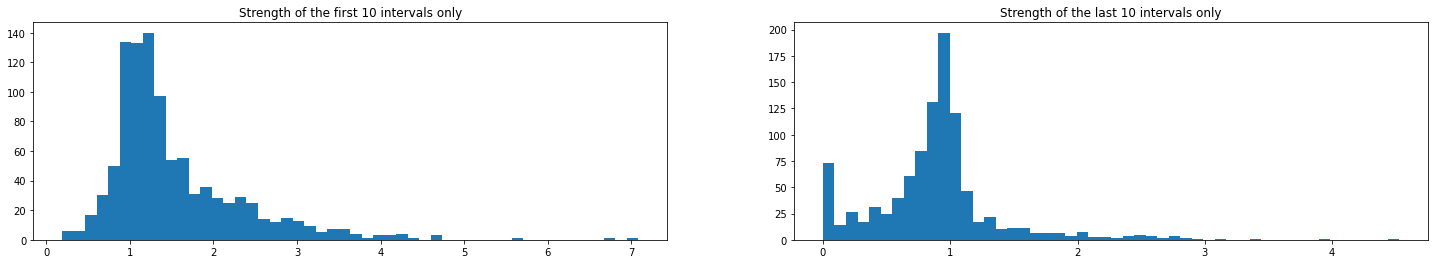

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(25, 4))
ax[0].hist(strength_of_first_intervals_10, bins=50)
ax[0].set_title("Strength of the first 10 intervals only");
ax[1].hist(strength_of_last_intervals_10, bins=50)
ax[1].set_title("Strength of the last 10 intervals only");

### Zeros <a id='zeros'></a>

The number zeros that exist in the session. Also normalized by length

In [20]:
zeros = (data.drop(columns=[0])==0).sum(axis=1)

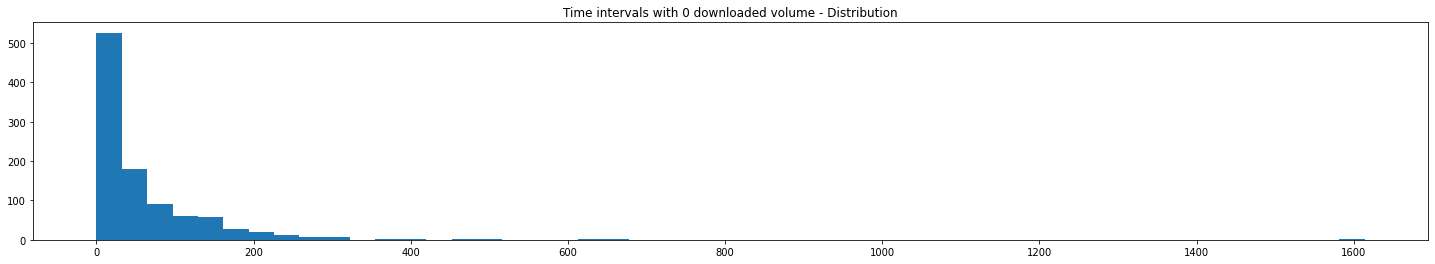

In [21]:
fig, ax = plt.subplots(figsize=(25, 4))
plt.hist(zeros, bins=50)
plt.title("Time intervals with 0 downloaded volume - Distribution");

In [22]:
# normalize zeros by the length of the video
zeros_n = zeros/number_of_intervals

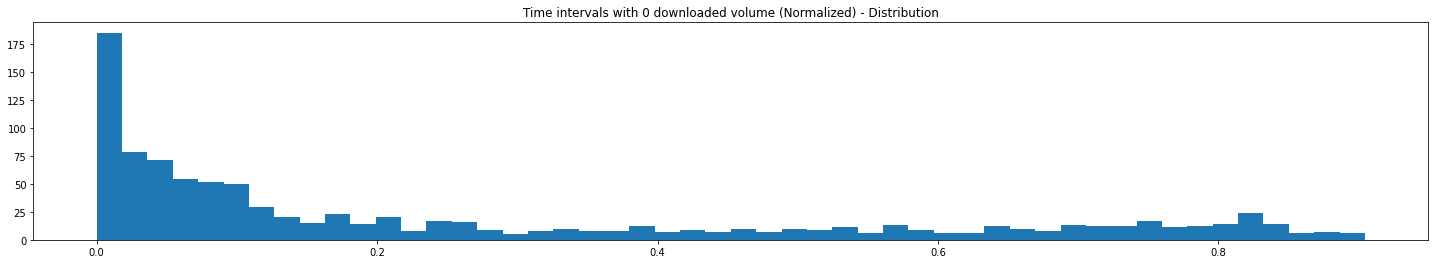

In [23]:
fig, ax = plt.subplots(figsize=(25, 4))
plt.hist(zeros_n, bins=50)
plt.title("Time intervals with 0 downloaded volume (Normalized) - Distribution");

### Groups of Zeros <a id="groups_of_zeros"></a>

The number of groups of consecutive zeros that exist in the session.

In [24]:
def find_group_of_zeros(y, consecutive_threshold=2):
    mask = ((y != y.shift()).cumsum())
    value_counts = mask.loc[y==0].value_counts()
    value_counts = value_counts[value_counts>=consecutive_threshold]
    return value_counts.shape[0]

In [25]:
group_of_zeros = data.drop(columns=[0]).apply(lambda x: find_group_of_zeros(x, consecutive_threshold=2), axis=1)

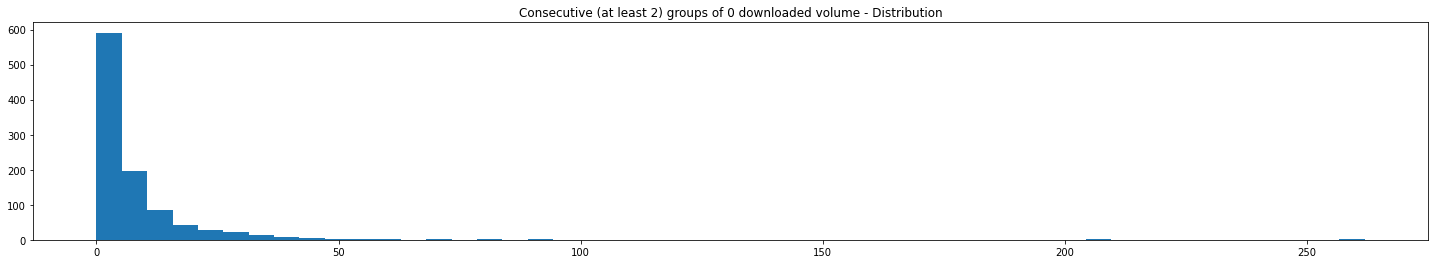

In [26]:
fig, ax = plt.subplots(figsize=(25, 4))
plt.hist(group_of_zeros, bins=50)
plt.title("Consecutive (at least 2) groups of 0 downloaded volume - Distribution");

In [27]:
group_of_zeros_th3 = data.drop(columns=[0]).apply(lambda x: find_group_of_zeros(x, consecutive_threshold=3), axis=1)

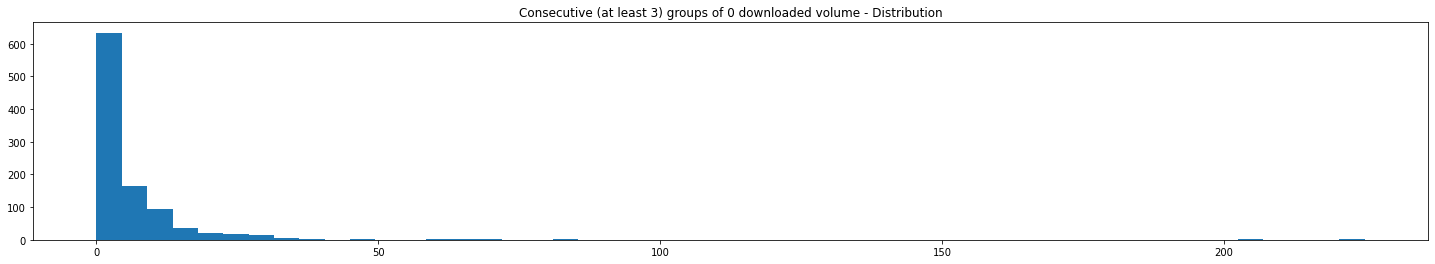

In [28]:
fig, ax = plt.subplots(figsize=(25, 4))
plt.hist(group_of_zeros_th3, bins=50)
plt.title("Consecutive (at least 3) groups of 0 downloaded volume - Distribution");

### Target <a id="target"></a>

In [29]:
target = data[0]

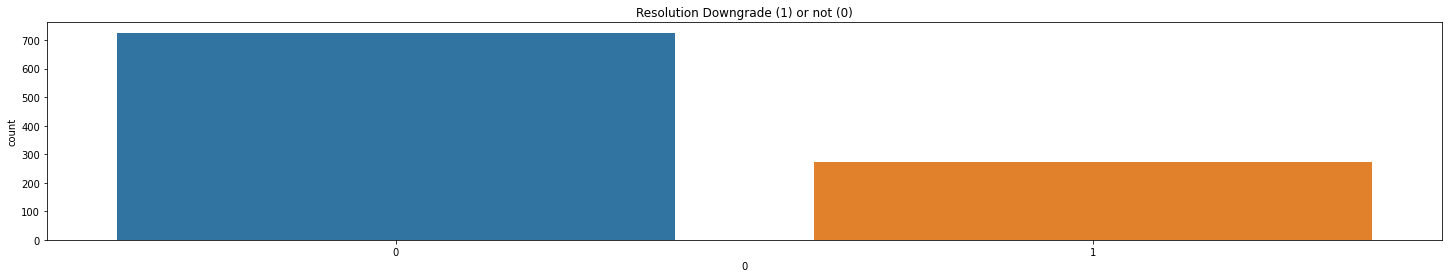

In [30]:
fig, ax = plt.subplots(figsize=(25, 4))
sns.countplot(x=target)
plt.title("Resolution Downgrade (1) or not (0)");

In [31]:
print(f"Target == 1 percentage: {100*len(target[target==1])/len(target)}%")
print(f"Target == 0 percentage: {100*len(target[target==0])/len(target)}%")

Target == 1 percentage: 27.4%
Target == 0 percentage: 72.6%


Somehow unbalanced. Will evaluate with **F-measure** instead of accuracy metric.

In [32]:
temp = pd.DataFrame(pd.concat([number_of_intervals, 
                               video_sizes,
                               target, zeros_n, 
                               group_of_zeros,
                               strength_of_first_intervals_1,
                               strength_of_first_intervals_2,
                               strength_of_first_intervals_10,
                               strength_of_last_intervals_1,
                               strength_of_last_intervals_2,
                               strength_of_last_intervals_10], axis=1).values, columns=['length', 
                                                                                        'size', 
                                                                                        'downgrade', 
                                                                                        'zeros_n', 
                                                                                        'group_of_zeros',
                                                                                        'strength_of_first_intervals_1',
                                                                                        'strength_of_first_intervals_2',
                                                                                        'strength_of_first_intervals_10',
                                                                                        'strength_of_last_intervals_1',
                                                                                        'strength_of_last_intervals_2',
                                                                                        'strength_of_last_intervals_10'])
temp['downgrade'] = temp['downgrade'].astype(str)

Observe length, size, zeros, group_of_zeros for the 2 classes

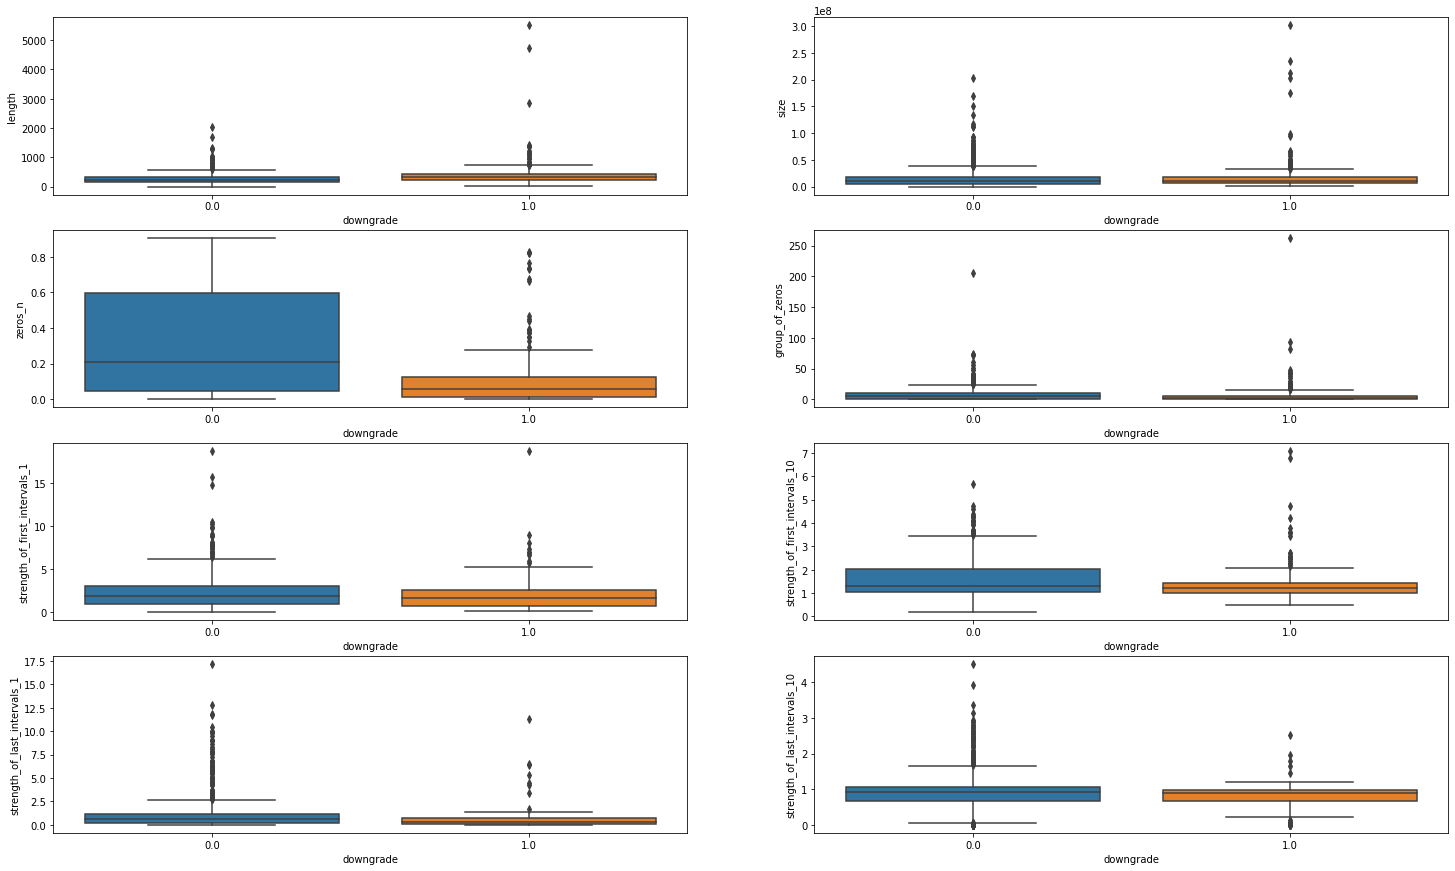

In [33]:
fig, ax = plt.subplots(4, 2, figsize=(25, 15))

sns.boxplot(x=temp['downgrade'], y=temp['length'], ax=ax[0][0]);
sns.boxplot(x=temp['downgrade'], y=temp['size'], ax=ax[0][1]);
sns.boxplot(x=temp['downgrade'], y=temp['zeros_n'], ax=ax[1][0]);
sns.boxplot(x=temp['downgrade'], y=temp['group_of_zeros'], ax=ax[1][1]);
sns.boxplot(x=temp['downgrade'], y=temp['strength_of_first_intervals_1'], ax=ax[2][0]);
sns.boxplot(x=temp['downgrade'], y=temp['strength_of_first_intervals_10'], ax=ax[2][1]);
sns.boxplot(x=temp['downgrade'], y=temp['strength_of_last_intervals_1'], ax=ax[3][0]);
sns.boxplot(x=temp['downgrade'], y=temp['strength_of_last_intervals_10'], ax=ax[3][1]);

Remove high positive outliers (over 0.9 quantile) and observe again

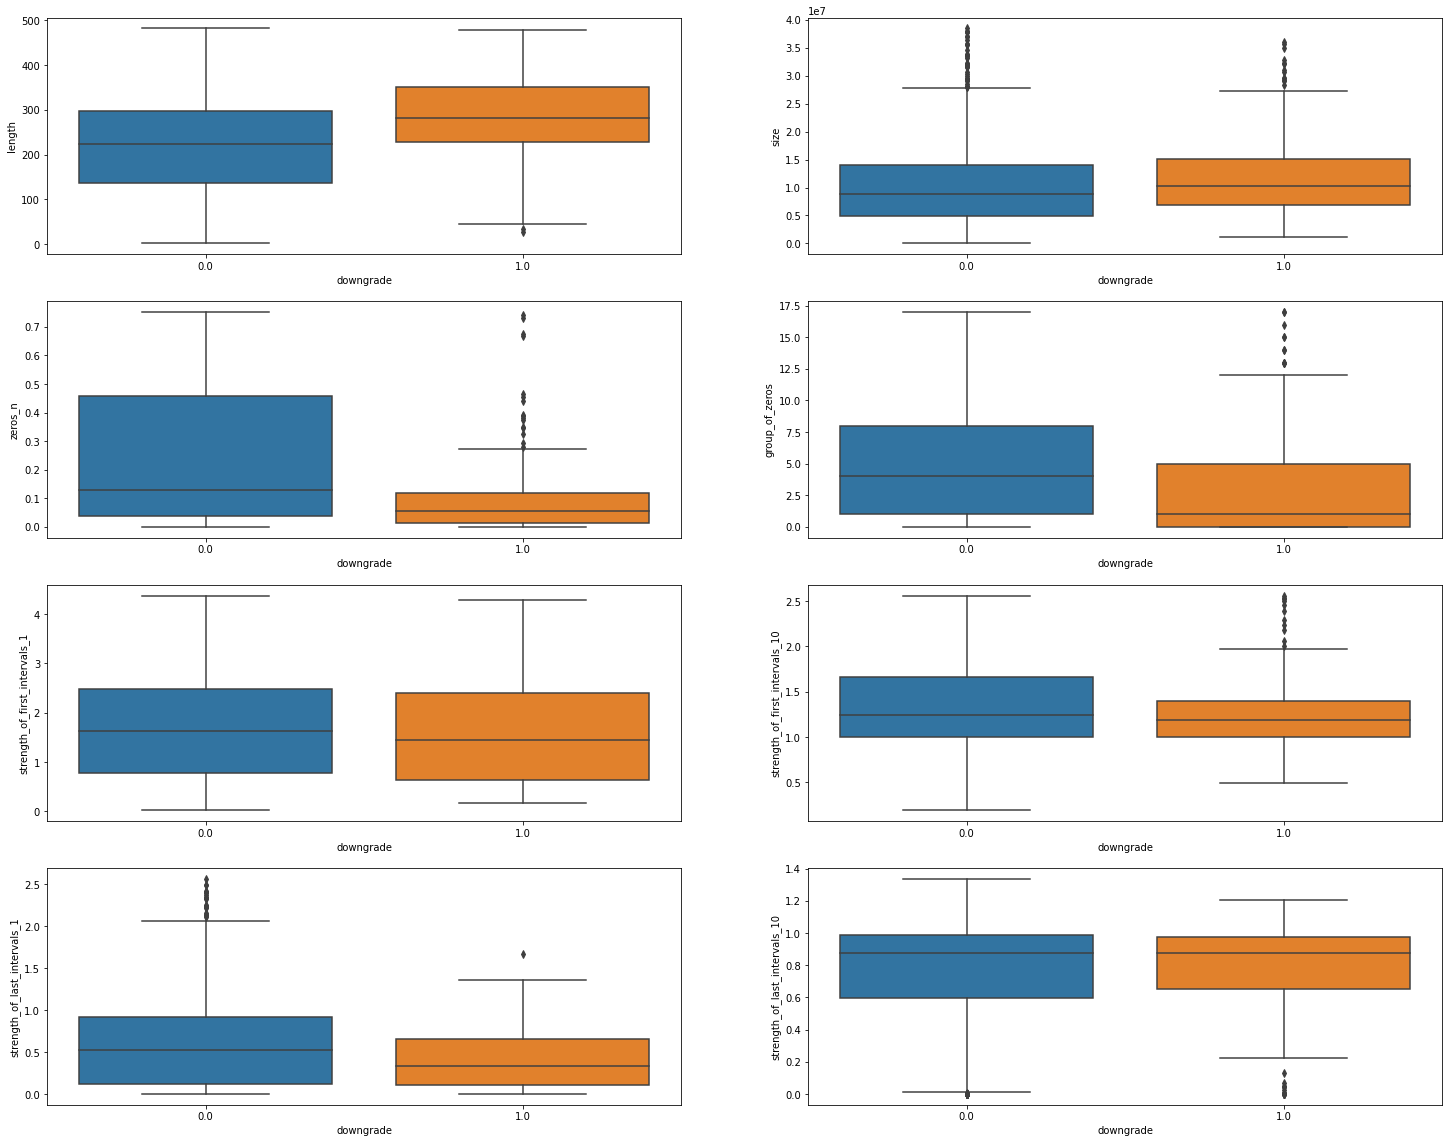

In [34]:
fig, ax = plt.subplots(4, 2, figsize=(25, 20))

sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['length'] < temp['length'].quantile(0.9)]['length'], ax=ax[0][0]);
sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['size'] < temp['size'].quantile(0.9)]['size'], ax=ax[0][1]);
sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['zeros_n'] < temp['zeros_n'].quantile(0.9)]['zeros_n'], ax=ax[1][0]);
sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['group_of_zeros'] < temp['group_of_zeros'].quantile(0.9)]['group_of_zeros'], ax=ax[1][1]);

sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['strength_of_first_intervals_1'] < temp['strength_of_first_intervals_1'].quantile(0.9)]['strength_of_first_intervals_1'], ax=ax[2][0]);
sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['strength_of_first_intervals_10'] < temp['strength_of_first_intervals_10'].quantile(0.9)]['strength_of_first_intervals_10'], ax=ax[2][1]);
sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['strength_of_last_intervals_1'] < temp['strength_of_last_intervals_1'].quantile(0.9)]['strength_of_last_intervals_1'], ax=ax[3][0]);
sns.boxplot(x=temp['downgrade'], y=temp.loc[temp['strength_of_last_intervals_10'] < temp['strength_of_last_intervals_10'].quantile(0.9)]['strength_of_last_intervals_10'], ax=ax[3][1]);

- The higher the length of the video, the higher the chance for a downgrade.
- Size is not so discriminative.
- Zeros and group_of_zeros show that less zeros or groups of them have a higher change for a downgrade.
- Strength of first or last intervals have small discriminations.

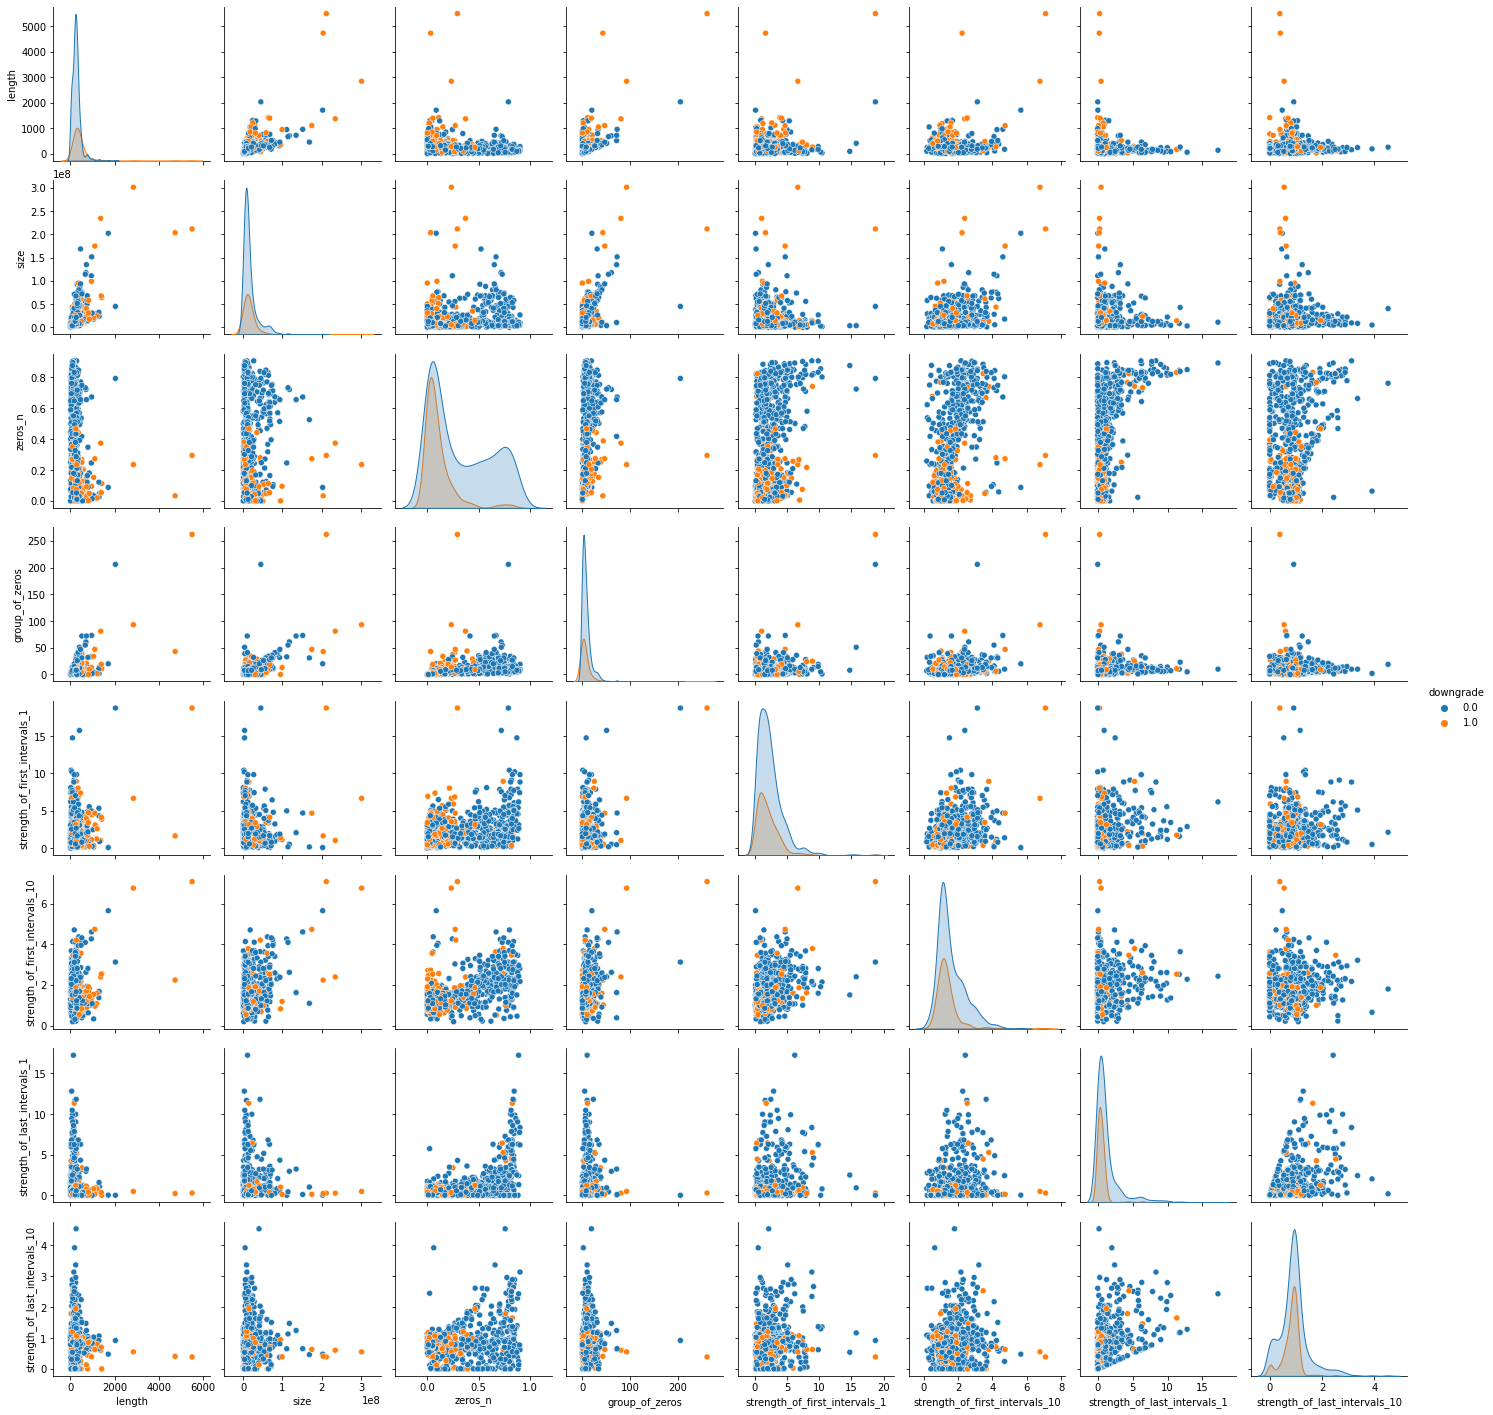

In [35]:
sns.pairplot(temp[['length', 'size', 'zeros_n', 'group_of_zeros', 'strength_of_first_intervals_1', 'strength_of_first_intervals_10', 
                   'strength_of_last_intervals_1', 'strength_of_last_intervals_10', 'downgrade']], hue = 'downgrade');

## Modeling <a id="modeling"></a>

In [36]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix
)

import joblib
import warnings
warnings.filterwarnings("ignore")

def print_scores(y_test, y_preds):
    print(f"Accuracy: {accuracy_score(y_test, y_preds):.3f}, F-measure: {f1_score(y_test, y_preds, average='macro'):.3f}")
    
def plot_confusion_matrix(y_test, y_preds):
    cf_matrix = confusion_matrix(y_test, y_preds)
    fig, ax = plt.subplots(figsize=(7,4))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted Label');
    ax.set_ylabel('True Label');
    
def train_predict_evaluate_model(model, X_train, y_train, X_test, y_test, plot=True):
    # StratifiedKFold is used as default
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring='f1_macro')

    print(f"CV F-measure mean: {scores.mean():.3f}, std: {scores.std():.3f}")

    # train on all train data
    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)

    print_scores(y_test, y_preds)

    if plot:
        plot_confusion_matrix(y_test, y_preds)    

C:\Users\JIM\anaconda3\envs\mobileum\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [37]:
data_file = 'data/vsa_sample_subset.csv'
data = read_file(file_name = data_file)
data

,0,1,2,3,4,5,6,7,8,9,...,5491,5492,5493,5494,5495,5496,5497,5498,5499,5500
0,0,121059,53520,51690.0,29.0,94378.0,81618.0,31736.0,75076.0,60509.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,58290,68266,14552.0,32369.0,5381.0,67110.0,61577.0,5486.0,29422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,184834,72531,133896.0,141118.0,114100.0,161196.0,149852.0,129972.0,63880.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,63526,20428,15263.0,16635.0,5560.0,17441.0,34080.0,5921.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,117264,83247,175868.0,99152.0,143166.0,44154.0,85661.0,111083.0,107040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,65024,72252,5827.0,32514.0,8028.0,21768.0,50828.0,66972.0,12040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,1,188329,34029,71081.0,114530.0,125860.0,100337.0,121001.0,109877.0,125772.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,0,119066,93309,34985.0,75296.0,114354.0,120184.0,44459.0,106646.0,111496.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,0,218013,69939,207734.0,101361.0,122930.0,112512.0,203464.0,131016.0,55795.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
SEED = 12
TARGET_NAME = 0 # I keep its name to 0
COLUMN_NAMES = data.drop(columns=TARGET_NAME).columns
TEST_SIZE_PERCENTAGE = 0.2
N_FOLDS = 4 # 4 folds such as 1 fold = 200 samples = test

In [39]:
X = data[COLUMN_NAMES]
y = data[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

print(f"train shape: {X_train.shape}, test shape: {X_test.shape}")

train shape: (800, 5500), test shape: (200, 5500)


### 1. Naive Baseline <a id="naive"></a>

Predict only the dominant class (0)

In [40]:
y_preds = np.zeros(shape=y_test.shape)

In [41]:
print_scores(y_test, y_preds)

Accuracy: 0.720, F-measure: 0.419


### 2. XGBoost on the raw data <a id="xgboost-raw-data"></a>

XGBoost handles NaNs

CV F-measure mean: 0.583, std: 0.031
Accuracy: 0.695, F-measure: 0.544


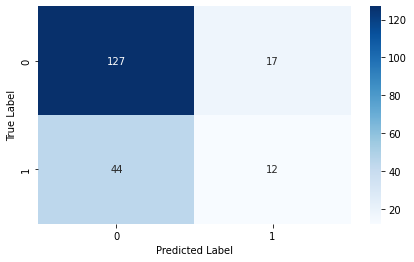

In [42]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

### 3. Fill NaNs with 0 <a id="fill-nans-0"></a>

Zero is a meaningfull number, because it denotes that no download happend in this interval.

In [43]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

#### 3.1 XGBoost

CV F-measure mean: 0.615, std: 0.007
Accuracy: 0.695, F-measure: 0.573


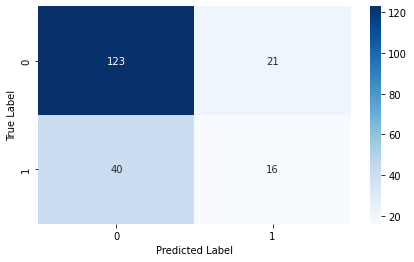

In [44]:
xgb = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(xgb, X_train, y_train, X_test, y_test)

#### 3.2 Random Forest

CV F-measure mean: 0.583, std: 0.019
Accuracy: 0.705, F-measure: 0.526


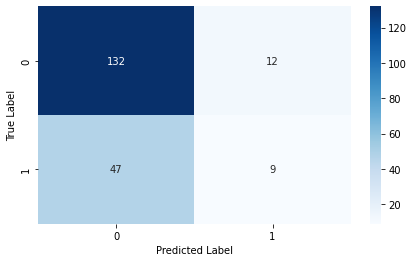

In [45]:
rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)

train_predict_evaluate_model(rf, X_train, y_train, X_test, y_test)

#### 3.3 Logistic Regression

CV F-measure mean: 0.552, std: 0.030
Accuracy: 0.630, F-measure: 0.560


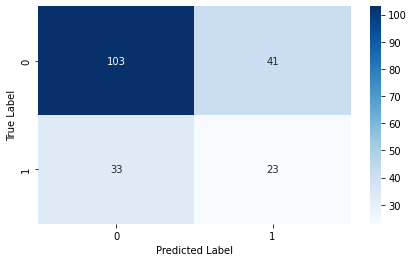

In [46]:
lr = LogisticRegression(random_state=SEED)

train_predict_evaluate_model(lr, X_train, y_train, X_test, y_test)

#### 3.4 Linear SVC

CV F-measure mean: 0.555, std: 0.038
Accuracy: 0.630, F-measure: 0.541


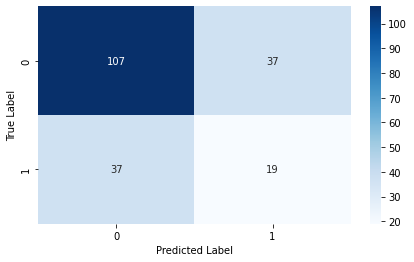

In [47]:
svc = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=SEED))

train_predict_evaluate_model(svc, X_train, y_train, X_test, y_test)

#### 3.5 Majority Voting

From the above confusion matrices I will discard random forest and use the other 3 algorithms for voting.

Logistic Regression and SVM seem a little better at classifying the '1' class and they will help to strong XGB model in the voting.

CV F-measure mean: 0.569, std: 0.043
Accuracy: 0.675, F-measure: 0.585


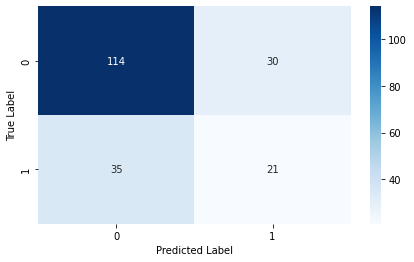

In [48]:
model = VotingClassifier(
                         estimators=[('xgb', xgb), ('lr', lr), ('svc', svc)],
                         voting='hard'
                        )

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

Evaluating mainly on CV, XGBoost has the highest performance, thus it will be used from now on.

### 4. Repeat elemets to fill all NaNs intervals <a id="repeat"></a>

Example: [1,2,3, nan, nan, nan, nan] -> [1,1,1,2,2,3,3]

In [49]:
def repeat_elemets_to_fill_intervals(x):

    total_intervals = len(x)
    not_nan_intervals = total_intervals-np.isnan(x).sum()
    repeats = total_intervals//not_nan_intervals
    number_of_overfilled = total_intervals % not_nan_intervals
    border = number_of_overfilled*(repeats+1)

    x[border:]=x[number_of_overfilled:not_nan_intervals].repeat(repeats) #the end
    x[:border]=x[:number_of_overfilled].repeat(repeats+1) #the beginning
    
    return x

In [50]:
X = data[COLUMN_NAMES]
y = data[TARGET_NAME]

X = X.apply(lambda x: repeat_elemets_to_fill_intervals(x), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

#### 4.1 XGBoost

CV F-measure mean: 0.542, std: 0.023
Accuracy: 0.715, F-measure: 0.581


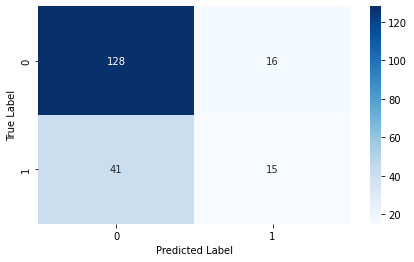

In [51]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

This approach resulted in worse performance.

### 5. Feature Engineering <a id="feat-eng"></a>

I will create the features that were already built through EDA and some more that I think might be important.

In [52]:
def number_of_peaks(x):
    return len(signal.find_peaks(x.dropna(), threshold=x.std()/10)[0])

def mean_peak_change(x):
    return np.diff(signal.find_peaks(x.dropna(), threshold=x.std()/10)[0]).mean()

def number_of_relative_minima(x):
    return len(signal.argrelmin(x.dropna().values)[0])

def number_of_relative_maxima(x):
    return len(signal.argrelmax(x.dropna().values)[0])

def mean_size_change(x):
    return np.mean(np.diff(x.dropna()))

In [53]:
X = data[COLUMN_NAMES]

data_f = data[[TARGET_NAME]]

In [54]:
data_f['length'] = len(X.columns) - X.isnull().sum(axis=1)
data_f['size'] = X.sum(axis=1)
data_f['size_mean'] = X.mean(axis=1)
data_f['size_std'] = X.std(axis=1)
data_f['size_skew'] = X.skew(axis=1)
data_f['size_skew'] = data_f['size_skew'].fillna(data_f['size_skew'].mean()) # when length < 3
data_f['mean_size_change'] = X.apply(lambda x: mean_size_change(x), axis=1)
data_f['zeros'] = (X==0).sum(axis=1)
data_f['zeros_n'] = data_f['zeros']/data_f['length']
data_f['group_of_zeros_2'] = X.apply(lambda x: find_group_of_zeros(x, consecutive_threshold=2), axis=1)
data_f['group_of_zeros_10'] = X.apply(lambda x: find_group_of_zeros(x, consecutive_threshold=10), axis=1)
data_f['finterval_str_first_1'] = X.apply(lambda x: strength_of_intervals(x, number_of_intervals=1, kind='first'), axis=1)
data_f['interval_str_first_2'] = X.apply(lambda x: strength_of_intervals(x, number_of_intervals=2, kind='first'), axis=1)
data_f['interval_str_first_10'] = X.apply(lambda x: strength_of_intervals(x, number_of_intervals=10, kind='first'), axis=1)
data_f['interval_str_last_1'] = X.apply(lambda x: strength_of_intervals(x, number_of_intervals=1, kind='last'), axis=1)
data_f['interval_str_last_2'] = X.apply(lambda x: strength_of_intervals(x, number_of_intervals=2, kind='last'), axis=1)
data_f['interval_str_last_10'] = X.apply(lambda x: strength_of_intervals(x, number_of_intervals=10, kind='last'), axis=1)
data_f['peaks'] = X.apply(lambda x: number_of_peaks(x), axis=1)
data_f['mean_peak_change'] = X.apply(lambda x: mean_peak_change(x), axis=1)
data_f['mean_peak_change'] = data_f['mean_peak_change'].fillna(0) # when there are less than 2 peaks
data_f['relative_minima'] = X.apply(lambda x: number_of_relative_minima(x), axis=1)
data_f['relative_maxima'] = X.apply(lambda x: number_of_relative_maxima(x), axis=1)

In [55]:
data_f

,0,length,size,size_mean,size_std,size_skew,mean_size_change,zeros,zeros_n,group_of_zeros_2,...,finterval_str_first_1,interval_str_first_2,interval_str_first_10,interval_str_last_1,interval_str_last_2,interval_str_last_10,peaks,mean_peak_change,relative_minima,relative_maxima
0,0,229,10692074.0,46690.279476,27628.117508,-0.641363,-530.833333,48,0.209607,2,...,2.592809,1.869543,1.375333,0.000621,0.000311,0.000062,12,16.636364,42,42
1,0,156,5638222.0,36142.448718,14934.665495,0.316170,-375.877419,0,0.000000,0,...,1.612785,1.750794,1.147919,0.000802,0.516830,0.928916,18,8.705882,48,46
2,0,256,23816288.0,93032.375000,49645.151112,-1.131519,-660.996078,50,0.195312,3,...,1.986771,1.383201,1.377046,0.174993,0.738883,1.166052,32,8.000000,69,72
3,0,199,3512736.0,17651.939698,13461.671146,1.793375,-227.606061,19,0.095477,5,...,3.598811,2.378039,1.013226,1.045777,1.056768,1.010586,41,4.750000,55,60
4,0,239,13428310.0,56185.397490,57664.243589,0.169620,-492.584034,113,0.472803,11,...,2.087090,1.784369,1.915713,0.000516,0.000258,0.000052,8,29.285714,21,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,296,12618653.0,42630.584459,32135.404543,1.117314,-213.355932,3,0.010135,0,...,1.525290,1.610065,0.855494,0.048885,0.463845,0.780768,74,3.972603,77,82
996,1,245,14608340.0,59625.877551,59243.902436,0.065828,-471.081967,114,0.465306,9,...,3.158511,1.864610,1.863681,1.230758,1.636395,1.947441,11,23.500000,32,39
997,0,215,13032757.0,60617.474419,50541.735484,-0.116408,-535.121495,70,0.325581,7,...,1.964219,1.751764,1.545896,0.075061,0.053747,0.010749,22,8.904762,39,46
998,0,263,21337477.0,81131.091255,55920.555065,-0.520746,-662.541985,75,0.285171,8,...,2.687170,1.774609,1.662666,0.547595,0.933224,1.317121,20,13.315789,48,55


In [56]:
X = data_f[[c for c in data_f.columns if c != TARGET_NAME]]
y = data_f[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

print(f"train shape: {X_train.shape}, test shape: {X_test.shape}")

train shape: (800, 20), test shape: (200, 20)


Since this approach has new features only, I will test all 4 algorithms again.

#### 5.1 XGBoost

CV F-measure mean: 0.622, std: 0.024
Accuracy: 0.735, F-measure: 0.634


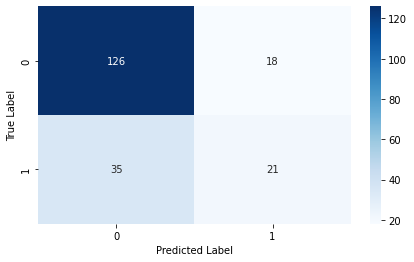

In [57]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

#### 5.2 Random Forest

CV F-measure mean: 0.617, std: 0.033
Accuracy: 0.730, F-measure: 0.593


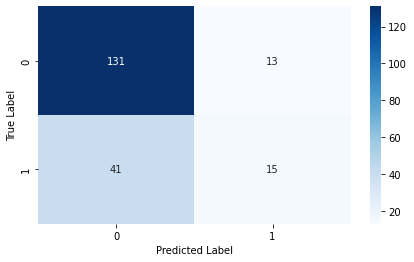

In [58]:
model = RandomForestClassifier(random_state=SEED, n_jobs=-1)

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

#### 5.3 Logistic Regression

CV F-measure mean: 0.511, std: 0.019
Accuracy: 0.725, F-measure: 0.518


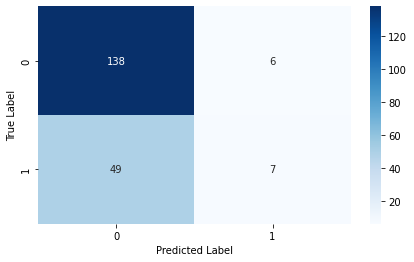

In [59]:
model = LogisticRegression(random_state=SEED)

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

#### 5.4 Linear SVC

CV F-measure mean: 0.600, std: 0.030
Accuracy: 0.720, F-measure: 0.545


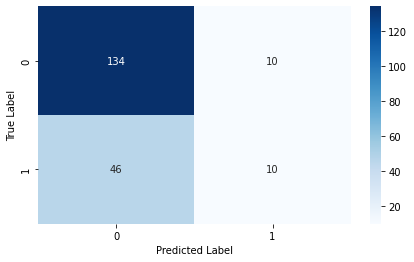

In [60]:
model = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=SEED))

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

From this feature engineering the XGBoost model was improved.

Until this moment our approaches have the following results:

| Approach      | CV F-measure | Test F-measure |
| ------------- | ------------ | -------------- |
| Naive (predict always 0) | - | 0.419 |
| XGBoost on raw data | 0.583 | 0.544 |
| Fill NaNs with 0 - XGBoost | 0.615 | 0.573 |
| Fill NaNs with 0 - Majority Voting | 0.569 | 0.585 |
| Repeat Elements to fill all intervals | 0.542 | 0.581 |
| Feature Engineering with 20 features | **0.622** | 0.634 |

### 6. Adding these features to the initial <a id="add-to-init"></a>

In [61]:
data = pd.concat([data, data_f[[c for c in data_f.columns if c != TARGET_NAME]]], axis=1)

X = data[[c for c in data.columns if c != TARGET_NAME]]
y = data[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

CV F-measure mean: 0.650, std: 0.039
Accuracy: 0.735, F-measure: 0.611


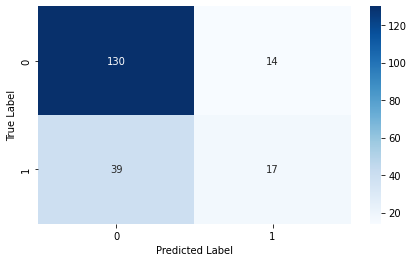

In [62]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

Performance actually increases to CV F-measure = 0.65

### 7. Feature Selection <a id="feat-sel"></a>

With 5500 features and only 1000 rows, we have to combat the curse of dimensionality, but also eliminate features with minimum redundancy and keep the ones with maximum relevance.

I will not use dimensionality techniques like PCA as the new feature space that it creates cannot be easily explained. With feature selection we can actually see which of the initial features are kept.

I will use ensemble feature selection. Three techniques:

- one filter (chi-square)
- one wrapper (SHAP)
- one embedded (XGBoost), and
- combine the feature rankings with Reciprocal Ranking.

Doing feature selection on the X_train

In [63]:
import shap
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import MinMaxScaler

data_file = 'data/vsa_sample_subset.csv'
data = read_file(file_name = data_file)

X = data[COLUMN_NAMES]
y = data[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

top_features = int(len(X_train.columns.values)*1) # all features
headers = X_train.columns.values

#### Chi-square

A fast filter method

In [64]:
X_train_norm = MinMaxScaler().fit_transform(X_train)

chi_selector = SelectKBest(chi2, k=top_features)
chi_selector.fit(X_train_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = pd.DataFrame(X_train_norm).loc[:, chi_support].columns.tolist()

rank_chi = pd.DataFrame(columns=['Feature', 'Score'])
for i in range(0,len(headers)):
    rank_chi.loc[-1] = [headers[i], chi_selector.scores_[i]] #save the time took to run
    rank_chi.index = rank_chi.index + 1
rank_chi = rank_chi.sort_values(by='Score', ascending=False).reset_index().drop(['index'],axis=1)
rank_chi['Rank'] = rank_chi.index

rank_chi

,Feature,Score,Rank
0,513.0,12.424992,0
1,522.0,10.451967,1
2,1099.0,10.020143,2
3,675.0,9.911598,3
4,1100.0,9.819765,4
...,...,...,...
5495,5496.0,NaN,5495
5496,5497.0,NaN,5496
5497,5498.0,NaN,5497
5498,5499.0,NaN,5498


#### Shap

A wrapper method

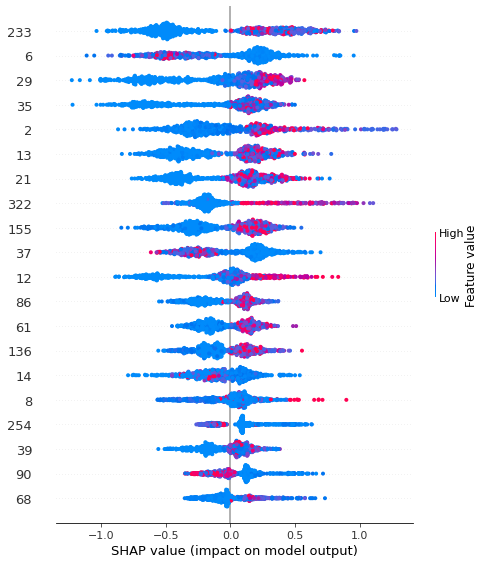

In [65]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=headers)

In [66]:
shapdf = pd.DataFrame(data=shap_values, columns=headers).mean().abs().sort_values(ascending=False)  # 1st row as the column names
feature_selection_df = shapdf.to_frame().reset_index()
shap_feature = feature_selection_df['index'].head(top_features).tolist()

shap_support = []
for feature in X_train.columns.values:
    if feature in shap_feature:
        shap_support.append(True)
    else:
        shap_support.append(False)
shap_support = np.asarray(shap_support)

rank_shap = feature_selection_df
rank_shap.rename(columns={'index':'Feature', 0:'Score'}, inplace=True)
rank_shap = rank_shap.sort_values(by=['Score'], ascending=False).reset_index().drop(['index'],axis=1).astype('object')
rank_shap['Rank'] = rank_shap.index
rank_shap

,Feature,Score,Rank
0,35,0.111727,0
1,233,0.096793,1
2,29,0.090046,2
3,12,0.083113,3
4,13,0.073546,4
...,...,...,...
5495,5499,0.0,5495
5496,5492,0.0,5496
5497,5482,0.0,5497
5498,5481,0.0,5498


#### Embedded XGBoost

In [67]:
embeded_selector = SelectFromModel(model, max_features=top_features)
embeded_selector.fit(X_train, y_train)

rank_exgb = pd.DataFrame(columns=['Feature', 'Score'])
for i in range(0,len(embeded_selector.estimator_.feature_importances_)):
    rank_exgb.loc[-1] = [headers[i], embeded_selector.estimator_.feature_importances_[i]] 
    rank_exgb.index = rank_exgb.index + 1
rank_exgb = rank_exgb.sort_values(by='Score', ascending=False).reset_index().drop(['index'],axis=1)
rank_exgb['Rank'] = rank_exgb.index
rank_exgb

,Feature,Score,Rank
0,233.0,0.030470,0
1,236.0,0.023162,1
2,412.0,0.022355,2
3,415.0,0.018456,3
4,83.0,0.017784,4
...,...,...,...
5495,2026.0,0.000000,5495
5496,2025.0,0.000000,5496
5497,2024.0,0.000000,5497
5498,2023.0,0.000000,5498


#### Ensemble Feature Selection

Combine the above 3 methods (chi-square, shap, embedded XGBoost) to get the overall best features according to reciprocal ranking.

In [68]:
rank_chi_for_esemble = rank_chi.sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)
rank_shap_for_esemble = rank_shap.copy().sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)
rank_exgb_for_esemble = rank_exgb.copy().sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)

fs = pd.DataFrame({'Feature':X.columns.sort_values(), 
                                      'Chi-2':rank_chi_for_esemble['Rank'],
                                      'SHAP':rank_shap_for_esemble['Rank'],
                                      'E_XGB':rank_exgb_for_esemble['Rank'] ,
                                     })

fs['BordaCount'] = np.sum(fs, axis=1)

fs['RecRank'] = 1/(1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['Chi-2']) + 
                   1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['SHAP']) +
                   1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['E_XGB'])
                 )

fs = fs.sort_values(['RecRank','Feature'] , ascending=True)
fs

,Feature,Chi-2,SHAP,E_XGB,BordaCount,RecRank
232,233,4174,1,0,4408,0.666560
34,35,4537,0,48,4620,0.979788
512,513,0,513,3550,4576,0.997778
235,236,4499,48,1,4784,1.920748
521,522,1,522,3582,4627,1.991274
...,...,...,...,...,...,...
4795,4796,4795,4794,2727,17112,1276.118024
4794,4795,4794,4793,2728,17110,1276.195116
4793,4794,4793,4792,2729,17108,1276.271997
4657,4658,4729,4657,2824,16868,1281.914536


Most important features are the following half seconds: 233, 35, 513, 236, 522

#### Train - evaluate based on top features

We are comparing with XGBoost trained on all features: CV F-measure=0.615, Test F-measure=0.573

In [69]:
for number_of_top_features in [2000, 1000, 500, 400, 300, 200, 100, 80, 50, 40, 30, 20, 10, 5]:
    
    print('='*20, f'number of top features = {number_of_top_features}', '='*20)

    cols_to_use = fs.sort_values(['RecRank','Feature'] , ascending=True)['Feature'][:number_of_top_features]

    X = data[cols_to_use]
    y = data[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

    train_predict_evaluate_model(model, X_train, y_train, X_test, y_test, plot=False)

==================== number of top features = 2000 ====================
CV F-measure mean: 0.594, std: 0.023
Accuracy: 0.720, F-measure: 0.585
==================== number of top features = 1000 ====================
CV F-measure mean: 0.604, std: 0.020
Accuracy: 0.710, F-measure: 0.570
==================== number of top features = 500 ====================
CV F-measure mean: 0.614, std: 0.010
Accuracy: 0.715, F-measure: 0.567
==================== number of top features = 400 ====================
CV F-measure mean: 0.621, std: 0.008
Accuracy: 0.690, F-measure: 0.556
==================== number of top features = 300 ====================
CV F-measure mean: 0.637, std: 0.005
Accuracy: 0.715, F-measure: 0.601
==================== number of top features = 200 ====================
CV F-measure mean: 0.623, std: 0.043
Accuracy: 0.715, F-measure: 0.601
==================== number of top features = 100 ====================
CV F-measure mean: 0.612, std: 0.022
Accuracy: 0.715, F-measure: 0.601
====

There are improvements doing feature selection. I will keep the number of top features = 40 as the best run, with CV=0.639 and Test=0.649

### 8. Feature Selection on the Engineered Features <a id="feat-sel-eng"></a>

In [70]:
X = data_f[[c for c in data_f.columns if c != TARGET_NAME]]
y = data_f[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

top_features = int(len(X_train.columns.values)*1) # all features
headers = X_train.columns.values

#### Chi-square

In [71]:
X_train_norm = MinMaxScaler().fit_transform(X_train)

chi_selector = SelectKBest(chi2, k=top_features)
chi_selector.fit(X_train_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = pd.DataFrame(X_train_norm).loc[:, chi_support].columns.tolist()

rank_chi = pd.DataFrame(columns=['Feature', 'Score'])
for i in range(0,len(headers)):
    rank_chi.loc[-1] = [headers[i], chi_selector.scores_[i]] #save the time took to run
    rank_chi.index = rank_chi.index + 1
rank_chi = rank_chi.sort_values(by='Score', ascending=False).reset_index().drop(['index'],axis=1)
rank_chi['Rank'] = rank_chi.index

rank_chi

,Feature,Score,Rank
0,zeros_n,32.121636,0
1,size_std,10.793056,1
2,interval_str_last_2,5.643084,2
3,relative_minima,5.522002,3
4,peaks,5.158466,4
5,group_of_zeros_10,4.921612,5
6,interval_str_last_1,4.916550,6
7,relative_maxima,4.502568,7
8,size_mean,2.845764,8
9,length,2.523890,9


#### Shap

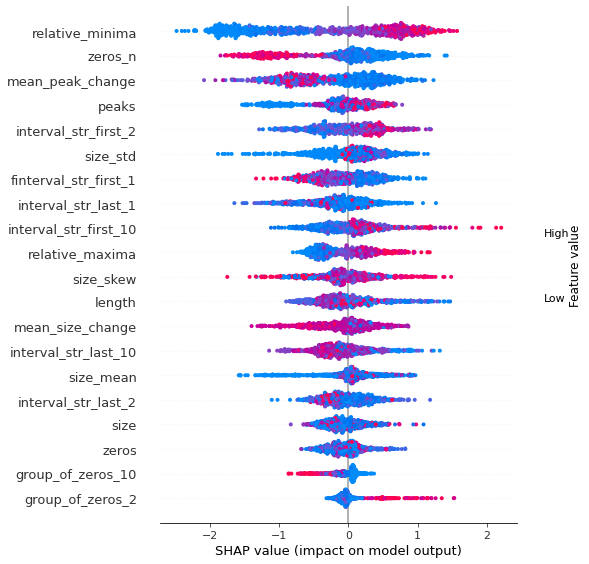

In [72]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=headers)

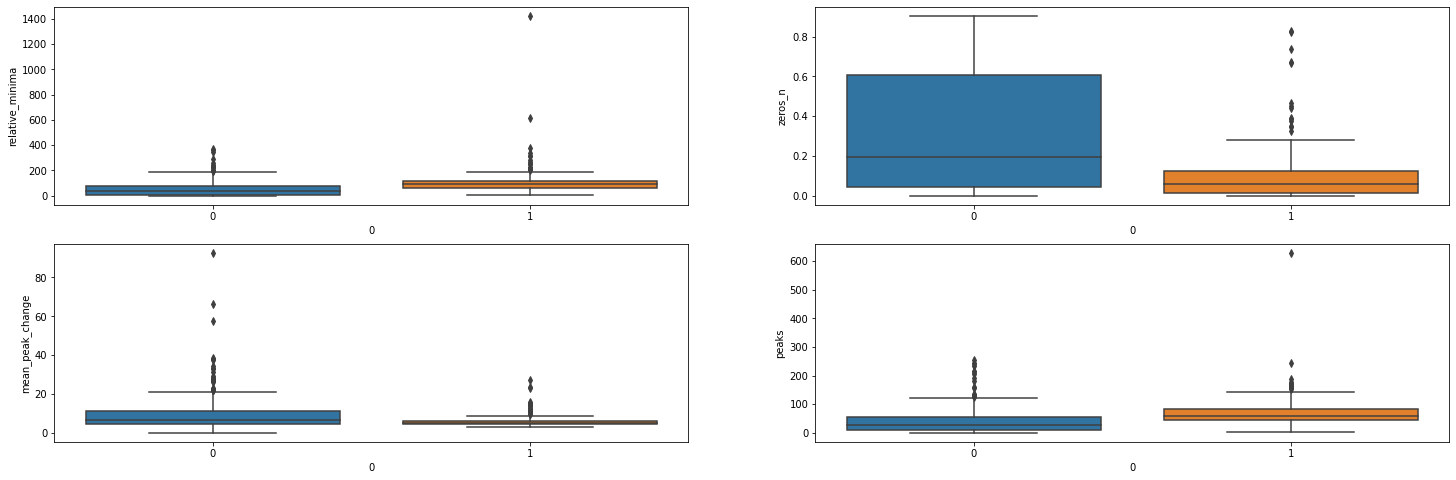

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(25,8))
sns.boxplot(x=y_train, y=X_train['relative_minima'], ax=ax[0][0]);
sns.boxplot(x=y_train, y=X_train['zeros_n'], ax=ax[0][1]);
sns.boxplot(x=y_train, y=X_train['mean_peak_change'], ax=ax[1][0]);
sns.boxplot(x=y_train, y=X_train['peaks'], ax=ax[1][1]);

In [74]:
shapdf = pd.DataFrame(data=shap_values, columns=headers).mean().abs().sort_values(ascending=False)  # 1st row as the column names
feature_selection_df = shapdf.to_frame().reset_index()
shap_feature = feature_selection_df['index'].head(top_features).tolist()

shap_support = []
for feature in X_train.columns.values:
    if feature in shap_feature:
        shap_support.append(True)
    else:
        shap_support.append(False)
shap_support = np.asarray(shap_support)

rank_shap = feature_selection_df
rank_shap.rename(columns={'index':'Feature', 0:'Score'}, inplace=True)
rank_shap = rank_shap.sort_values(by=['Score'], ascending=False).reset_index().drop(['index'],axis=1).astype('object')
rank_shap['Rank'] = rank_shap.index
rank_shap

,Feature,Score,Rank
0,relative_minima,0.356738,0
1,mean_peak_change,0.211363,1
2,peaks,0.155188,2
3,interval_str_last_1,0.14844,3
4,zeros_n,0.132731,4
5,interval_str_last_10,0.083216,5
6,mean_size_change,0.075704,6
7,relative_maxima,0.071601,7
8,finterval_str_first_1,0.061652,8
9,size,0.060221,9


#### Embedded XGBoost

In [75]:
embeded_selector = SelectFromModel(model, max_features=top_features)
embeded_selector.fit(X_train, y_train)

rank_exgb = pd.DataFrame(columns=['Feature', 'Score'])
for i in range(0,len(embeded_selector.estimator_.feature_importances_)):
    rank_exgb.loc[-1] = [headers[i], embeded_selector.estimator_.feature_importances_[i]] 
    rank_exgb.index = rank_exgb.index + 1
rank_exgb = rank_exgb.sort_values(by='Score', ascending=False).reset_index().drop(['index'],axis=1)
rank_exgb['Rank'] = rank_exgb.index
rank_exgb

,Feature,Score,Rank
0,relative_minima,0.160349,0
1,group_of_zeros_10,0.086113,1
2,peaks,0.068258,2
3,zeros_n,0.058579,3
4,relative_maxima,0.051893,4
5,size_mean,0.050514,5
6,zeros,0.049075,6
7,mean_peak_change,0.045517,7
8,group_of_zeros_2,0.043852,8
9,interval_str_first_10,0.043165,9


#### Ensemble Feature Selection

In [76]:
rank_chi_for_esemble = rank_chi.sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)
rank_shap_for_esemble = rank_shap.copy().sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)
rank_exgb_for_esemble = rank_exgb.copy().sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)

fs = pd.DataFrame({'Feature':X.columns.sort_values(), 
                                      'Chi-2':rank_chi_for_esemble['Rank'],
                                      'SHAP':rank_shap_for_esemble['Rank'],
                                      'E_XGB':rank_exgb_for_esemble['Rank'] ,
                                     })

fs['BordaCount'] = np.sum(fs, axis=1)

fs['RecRank'] = 1/(1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['Chi-2']) + 
                   1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['SHAP']) +
                   1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['E_XGB'])
                 )

fs = fs.sort_values(['RecRank'] , ascending=True)
fs

,Feature,Chi-2,SHAP,E_XGB,BordaCount,RecRank
13,relative_minima,3,0,0,3,0.444444
19,zeros_n,0,4,3,7,0.689655
11,peaks,4,2,2,8,1.153846
1,group_of_zeros_10,5,12,1,18,1.344828
9,mean_peak_change,10,1,7,18,1.396825
17,size_std,1,19,16,36,1.642512
5,interval_str_last_1,6,3,11,20,2.100000
7,interval_str_last_2,2,14,17,33,2.195122
12,relative_maxima,7,7,4,18,2.222222
15,size_mean,8,18,5,31,3.026549


#### Train - evaluate based on top features

We are comparing with XGBoost trained on all features: CV F-measure=0.622, Test F-measure=0.634

In [77]:
for number_of_top_features in range(20, 1, -1):
    
    print('='*20, f'number of top features = {number_of_top_features}', '='*20)

    # It is very important to sort te features as XGBoost cares about feature order
    cols_to_use = np.sort(fs.sort_values(['RecRank'] , ascending=True)['Feature'][:number_of_top_features])
    
    X = data_f[cols_to_use]
    y = data_f[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

    train_predict_evaluate_model(model, X_train, y_train, X_test, y_test, plot=False)


==================== number of top features = 20 ====================
CV F-measure mean: 0.643, std: 0.040
Accuracy: 0.730, F-measure: 0.619
==================== number of top features = 19 ====================
CV F-measure mean: 0.618, std: 0.017
Accuracy: 0.730, F-measure: 0.613
==================== number of top features = 18 ====================
CV F-measure mean: 0.607, std: 0.014
Accuracy: 0.735, F-measure: 0.604
==================== number of top features = 17 ====================
CV F-measure mean: 0.626, std: 0.020
Accuracy: 0.730, F-measure: 0.586
==================== number of top features = 16 ====================
CV F-measure mean: 0.628, std: 0.023
Accuracy: 0.700, F-measure: 0.548
==================== number of top features = 15 ====================
CV F-measure mean: 0.637, std: 0.025
Accuracy: 0.720, F-measure: 0.599
==================== number of top features = 14 ====================
CV F-measure mean: 0.655, std: 0.029
Accuracy: 0.725, F-measure: 0.596
=============

The highest CV Score is with the top 14 features

CV F-measure mean: 0.655, std: 0.029
Accuracy: 0.725, F-measure: 0.596


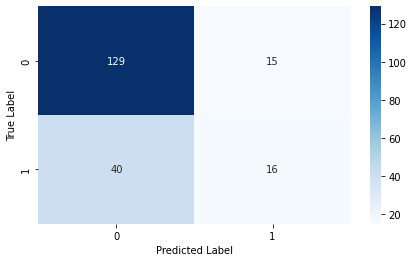

In [78]:
cols_to_use = np.sort(fs.sort_values(['RecRank'] , ascending=True)['Feature'][:14])

X = data_f[cols_to_use]
y = data_f[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

### 9. Feature Selection on Initial + Engineered Features <a id="feat-sel-eng2"></a>

In [79]:
data_file = 'data/vsa_sample_subset.csv'
data = read_file(file_name = data_file)

data = pd.concat([data, data_f[[c for c in data_f.columns if c != TARGET_NAME]]], axis=1)

X = data[[c for c in data.columns if c != TARGET_NAME]]
y = data[TARGET_NAME]

X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

top_features = int(len(X_train.columns.values)*1) # all features
headers = X_train.columns.values

#### Chi-square

A fast filter method

In [80]:
X_train_norm = MinMaxScaler().fit_transform(X_train)

chi_selector = SelectKBest(chi2, k=top_features)
chi_selector.fit(X_train_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = pd.DataFrame(X_train_norm).loc[:, chi_support].columns.tolist()

rank_chi = pd.DataFrame(columns=['Feature', 'Score'])
for i in range(0,len(headers)):
    rank_chi.loc[-1] = [headers[i], chi_selector.scores_[i]] #save the time took to run
    rank_chi.index = rank_chi.index + 1
rank_chi = rank_chi.sort_values(by='Score', ascending=False).reset_index().drop(['index'],axis=1)
rank_chi['Rank'] = rank_chi.index

rank_chi

,Feature,Score,Rank
0,zeros_n,32.121636,0
1,513,12.424992,1
2,size_std,10.793056,2
3,522,10.451967,3
4,1099,10.020143,4
...,...,...,...
5515,5496,NaN,5515
5516,5497,NaN,5516
5517,5498,NaN,5517
5518,5499,NaN,5518


#### Shap

A wrapper method

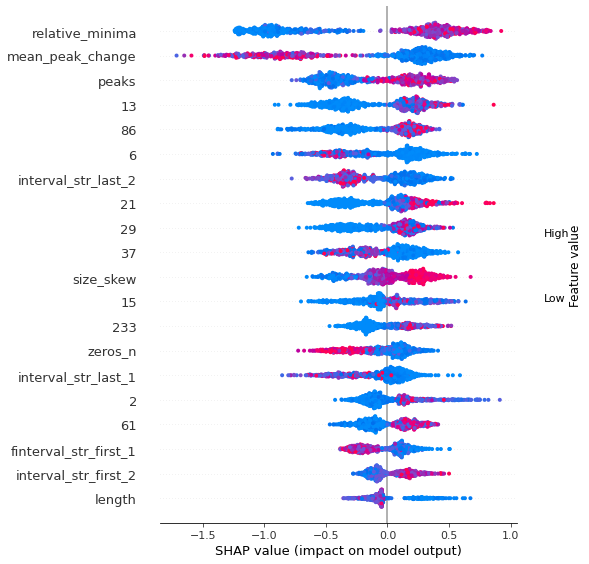

In [81]:
model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=headers)

In [82]:
shapdf = pd.DataFrame(data=shap_values, columns=headers).mean().abs().sort_values(ascending=False)  # 1st row as the column names
feature_selection_df = shapdf.to_frame().reset_index()
shap_feature = feature_selection_df['index'].head(top_features).tolist()

shap_support = []
for feature in X_train.columns.values:
    if feature in shap_feature:
        shap_support.append(True)
    else:
        shap_support.append(False)
shap_support = np.asarray(shap_support)

rank_shap = feature_selection_df
rank_shap.rename(columns={'index':'Feature', 0:'Score'}, inplace=True)
rank_shap = rank_shap.sort_values(by=['Score'], ascending=False).reset_index().drop(['index'],axis=1).astype('object')
rank_shap['Rank'] = rank_shap.index
rank_shap

,Feature,Score,Rank
0,relative_minima,0.179779,0
1,mean_peak_change,0.169529,1
2,peaks,0.12417,2
3,86,0.100217,3
4,interval_str_last_2,0.073561,4
...,...,...,...
5515,5494,0.0,5515
5516,5495,0.0,5516
5517,5496,0.0,5517
5518,5497,0.0,5518


#### Embedded XGBoost

In [83]:
embeded_selector = SelectFromModel(model, max_features=top_features)
embeded_selector.fit(X_train, y_train)

rank_exgb = pd.DataFrame(columns=['Feature', 'Score'])
for i in range(0,len(embeded_selector.estimator_.feature_importances_)):
    rank_exgb.loc[-1] = [headers[i], embeded_selector.estimator_.feature_importances_[i]] 
    rank_exgb.index = rank_exgb.index + 1
rank_exgb = rank_exgb.sort_values(by='Score', ascending=False).reset_index().drop(['index'],axis=1)
rank_exgb['Rank'] = rank_exgb.index
rank_exgb

,Feature,Score,Rank
0,relative_minima,0.056716,0
1,504,0.022168,1
2,467,0.019442,2
3,223,0.019086,3
4,group_of_zeros_10,0.017810,4
...,...,...,...
5515,2005,0.000000,5515
5516,2004,0.000000,5516
5517,2003,0.000000,5517
5518,2002,0.000000,5518


#### Ensemble Feature Selection

Combine the above 3 methods to get the overall best features voted by the 3 of them

In [84]:
rank_chi['Feature'] = rank_chi['Feature'].astype(str)
rank_shap['Feature'] = rank_shap['Feature'].astype(str)
rank_exgb['Feature'] = rank_exgb['Feature'].astype(str)

rank_chi_for_esemble = rank_chi.sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)
rank_shap_for_esemble = rank_shap.copy().sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)
rank_exgb_for_esemble = rank_exgb.copy().sort_values(by='Feature', ascending=True).reset_index().drop(['index'],axis=1)

fs = pd.DataFrame({'Feature':X.columns.sort_values(), 
                                      'Chi-2':rank_chi_for_esemble['Rank'],
                                      'SHAP':rank_shap_for_esemble['Rank'],
                                      'E_XGB':rank_exgb_for_esemble['Rank'] ,
                                     })

fs['BordaCount'] = np.sum(fs, axis=1)

fs['RecRank'] = 1/(1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['Chi-2']) + 
                   1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['SHAP']) +
                   1/(1+ fs.drop(['Feature', 'BordaCount'], axis=1)['E_XGB'])
                 )

fs = fs.sort_values(['RecRank','Feature'] , ascending=True)
fs.head(10)

,Feature,Chi-2,SHAP,E_XGB,BordaCount,RecRank
5513,relative_minima,358,0,0,358,0.499305
5519,zeros_n,0,8,49,57,0.884086
5509,mean_peak_change,3903,1,77,3981,1.949026
4490,504,4120,201,1,4322,1.979441
4590,513,1,520,3672,4193,1.991272
5511,peaks,436,2,11,449,2.386891
5517,size_std,2,37,59,98,2.657343
4078,467,4216,198,2,4416,2.953376
4690,522,3,141,14,158,3.089195
5345,86,4550,3,90,4643,3.828356


#### Train - evaluate based on top features

We are comparing with XGBoost trained on all features: CV F-measure=0.622, Test F-measure=0.634

In [85]:
for number_of_top_features in [200, 150, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 5]:
    
    print('='*20, f'number of top features = {number_of_top_features}', '='*20)

    # It is very important to sort te features as XGBoost cares about feature order
    cols_to_use = np.sort(fs.sort_values(['RecRank'] , ascending=True)['Feature'][:number_of_top_features])

    X_train, X_test, y_train, y_test = train_test_split(X[cols_to_use], y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

    train_predict_evaluate_model(model, X_train, y_train, X_test, y_test, plot=False)


==================== number of top features = 200 ====================
CV F-measure mean: 0.657, std: 0.031
Accuracy: 0.735, F-measure: 0.611
==================== number of top features = 150 ====================
CV F-measure mean: 0.663, std: 0.039
Accuracy: 0.750, F-measure: 0.636
==================== number of top features = 100 ====================
CV F-measure mean: 0.640, std: 0.027
Accuracy: 0.745, F-measure: 0.612
==================== number of top features = 90 ====================
CV F-measure mean: 0.656, std: 0.027
Accuracy: 0.725, F-measure: 0.596
==================== number of top features = 80 ====================
CV F-measure mean: 0.657, std: 0.050
Accuracy: 0.715, F-measure: 0.581
==================== number of top features = 70 ====================
CV F-measure mean: 0.653, std: 0.036
Accuracy: 0.695, F-measure: 0.566
==================== number of top features = 60 ====================
CV F-measure mean: 0.642, std: 0.032
Accuracy: 0.720, F-measure: 0.616
==========

The highest CV Score is with the top 150 features

CV F-measure mean: 0.663, std: 0.039
Accuracy: 0.750, F-measure: 0.636


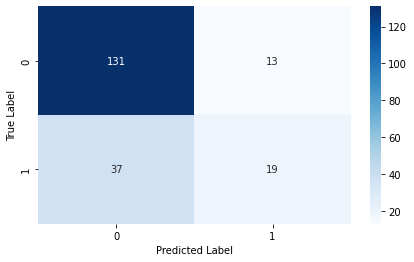

In [86]:
cols_to_use = np.sort(fs.sort_values(['RecRank'] , ascending=True)['Feature'][:150])

X_train, X_test, y_train, y_test = train_test_split(X[cols_to_use], y, test_size=TEST_SIZE_PERCENTAGE, random_state=SEED)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

model = XGBClassifier(random_state=SEED, n_jobs=-1, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

train_predict_evaluate_model(model, X_train, y_train, X_test, y_test)

## Save Model

In [87]:
joblib.dump(model, 'trained_models/xgboost-feature-engineering-selection-150-features.joblib')

['trained_models/xgboost-feature-engineering-selection-150-features.joblib']

## Conclusions <a id='conc'></a>

Our approaches have the following results:

| Approach      | CV F-measure | Test F-measure |
| ------------- | ------------ | -------------- |
| Naive (predict always 0) | - | 0.419 |
| XGBoost on raw data | 0.583 | 0.544 |
| Fill NaNs with 0 - XGBoost | 0.615 | 0.573 |
| Fill NaNs with 0 - Majority Voting | 0.569 | 0.585 | 
| Repeat Elements to fill all intervals | 0.542 | 0.581 |
| Feature Engineering with 20 features | 0.622 | 0.634 |
| Feature Selection on Initail Features | 0.639 | 0.649 |
| Feature Selection on the Engineered Features | 0.655 | 0.596 |
| Feature Selection on Initial + Engineered Features | 0.663 | 0.636 |

We managed to create a model with 0.663 Cross Validation F-measure score and 0.636 Test F-measure score (Accuracy = 0.75).

This model was the result of an ensemble feature selection to the feature engineering process (20 new features) + the initial features. The top 150 features were kept to construct this model.

13 of our 20 engineered features made it to the top 150 and some of them were the most important overall like:
    
- mean_peak_change
- relative_minima
- peaks
- zeros_n
- size_std
- interval strengths

Below we can see the impact of some of the top features.

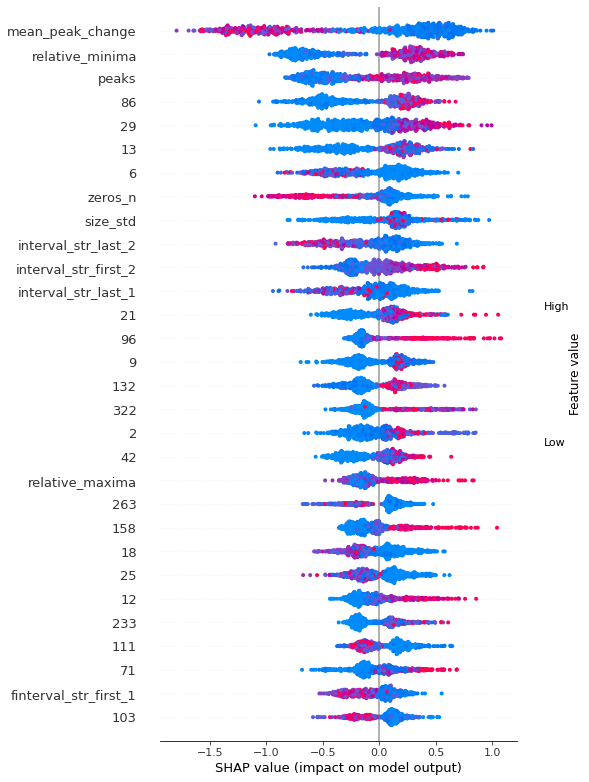

In [88]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=cols_to_use, max_display=30)

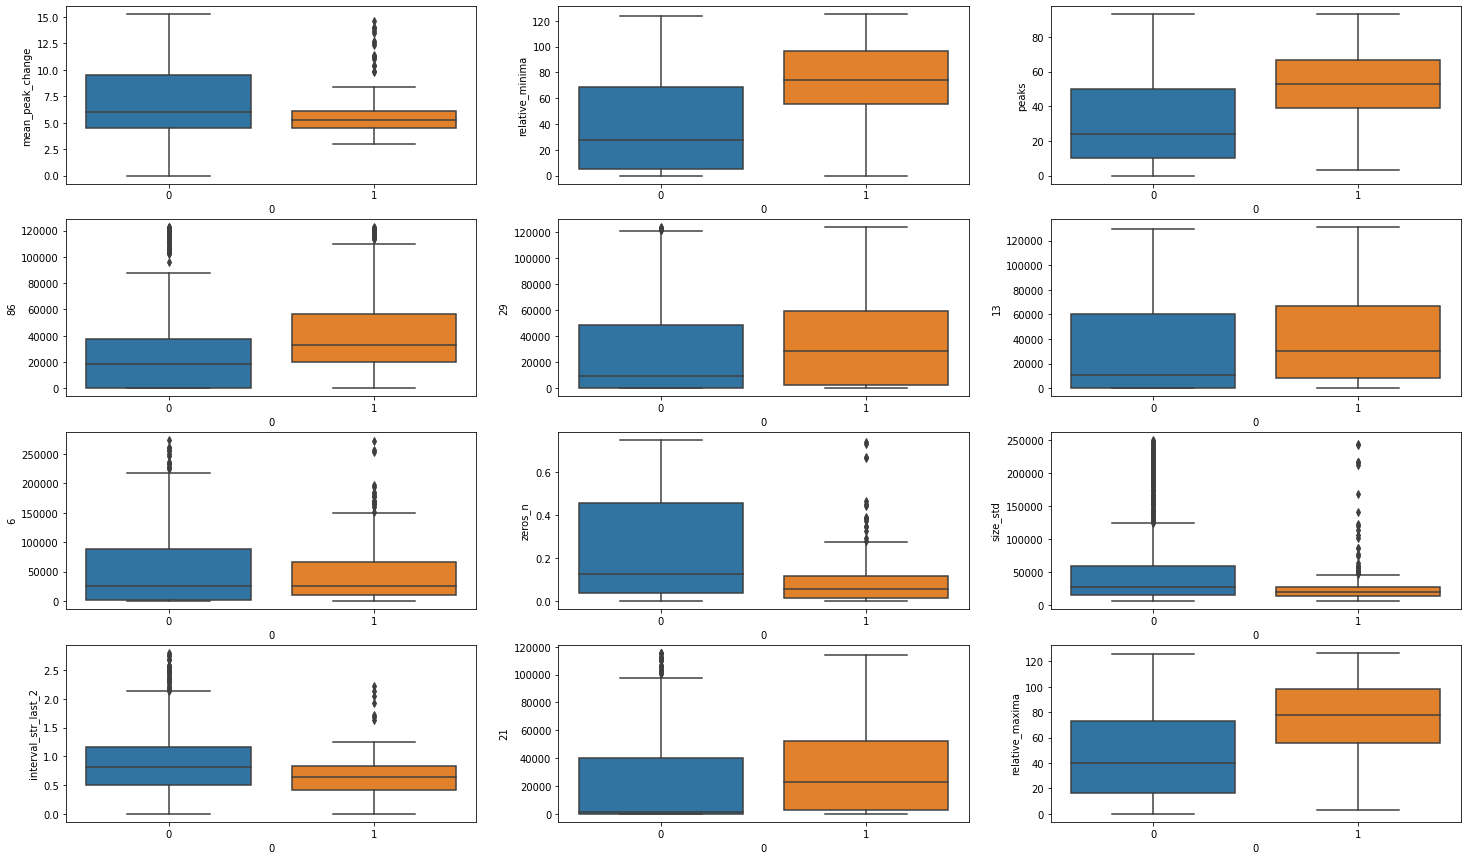

In [89]:
fig, ax = plt.subplots(4, 3, figsize=(25,15))
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['mean_peak_change'] < X['mean_peak_change'].quantile(0.9)]['mean_peak_change'], ax=ax[0][0]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['relative_minima'] < X['relative_minima'].quantile(0.9)]['relative_minima'], ax=ax[0][1]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['peaks'] < X['peaks'].quantile(0.9)]['peaks'], ax=ax[0][2]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['86'] < X['86'].quantile(0.9)]['86'], ax=ax[1][0]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['29'] < X['29'].quantile(0.9)]['29'], ax=ax[1][1]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['13'] < X['13'].quantile(0.9)]['13'], ax=ax[1][2]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['6'] < X['6'].quantile(0.9)]['6'], ax=ax[2][0]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['zeros_n'] < X['zeros_n'].quantile(0.9)]['zeros_n'], ax=ax[2][1]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['size_std'] < X['size_std'].quantile(0.9)]['size_std'], ax=ax[2][2]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['interval_str_last_2'] < X['interval_str_last_2'].quantile(0.9)]['interval_str_last_2'], ax=ax[3][0]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['21'] < X['21'].quantile(0.9)]['21'], ax=ax[3][1]);
sns.boxplot(x=data[TARGET_NAME], y=X.loc[X['relative_maxima'] < X['relative_maxima'].quantile(0.9)]['relative_maxima'], ax=ax[3][2]);

## Next Steps <a id='next-steps'></a>

- Create more features
- Since data is unbalanced, try some under- or over-sampling techniques
- Hyper-parameter tuning
- Refactor code and transition to .py